# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# vykundos?
##
# unzip processed_celeba_small.zip
##

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor()
                                   ])
    dataset = datasets.ImageFolder(data_dir, transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

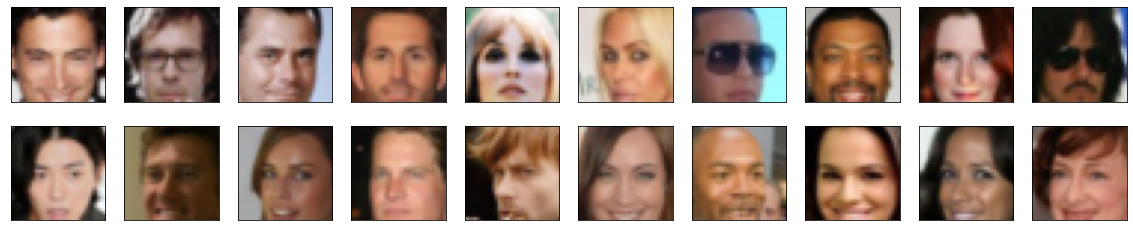

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    return (feature_range[1] - feature_range[0]) * x + feature_range[0]

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[1]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9373)
Max:  tensor(0.7647)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv2d_norm_lrelu(in_channel, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, negative_slope=0.2):
    """
    conv2d layer with optional batch normalization and ReLU activation
    """
    
    layers = []

    l1 = nn.Conv2d(in_channel, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(l1)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    layers.append(nn.LeakyReLU(negative_slope=negative_slope))
    
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv = nn.Sequential(
                                    conv2d_norm_lrelu(3, conv_dim, batch_norm=False),  # -> 16x16
                                    conv2d_norm_lrelu(conv_dim, conv_dim*2),  # -> 8x8
                                    conv2d_norm_lrelu(conv_dim*2, conv_dim*4),  # -> 4x4
                                )
        self.fc = nn.Linear(4*4 * conv_dim*4, 1)
#         self.drop = nn.Dropout(0.5)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = self.conv(x)
        # flatten
        out = out.view(-1, 4*4 * self.conv_dim*4)
#         print(f"flattened {out.shape}")
        out = self.fc(out)
#         out = self.drop(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv2d_norm_relu(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    """
    ConvTranspose2d layer with batch normalization and ReLU
    """
    deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    bnorm = nn.BatchNorm2d(out_channels)
    relu = nn.ReLU()
    
    net = nn.Sequential(deconv, bnorm, relu)
        
    return net

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        self.fc = nn.Linear(z_size, 4*conv_dim * 4*4) # -> 4x4
        
        self.dcnet = nn.Sequential(
                                deconv2d_norm_relu(4*conv_dim, 2*conv_dim), # -> 8x8
                                deconv2d_norm_relu(2*conv_dim, conv_dim), # -> 16x16
                                nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1, bias=False), # -> 32x32
                                nn.Tanh()
                                )
#         self.drop = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
#         out = self.drop(out)
        # unflatten
        out = out.view(-1, 4*self.conv_dim, 4, 4)
        # upsampling
        out = self.dcnet(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight, std=0.02)
        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (dcnet): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

device = 'cpu'
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    device = 'cuda'
    print('Training on GPU!')

print(f"Training device is {device}")

Training on GPU!
Training device is cuda


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
#     batch_size = D_out.shape[0]
    D_out = D_out.squeeze()
    
    criterion = nn.BCEWithLogitsLoss()
        
    loss = criterion(D_out, torch.ones_like(D_out).to(device)*0.9)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    D_out = D_out.squeeze()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out, torch.zeros_like(D_out).to(device)*0.9)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr = 0.0002
betas = (0.5, 0.999)

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, betas)
g_optimizer = optim.Adam(G.parameters(), lr, betas)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images).to(device)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            D.train()
            G.train()
            
            d_optimizer.zero_grad()
            # 1. Train the discriminator on real and fake images
            d_real_loss = real_loss(D(real_images))
            
            # noise vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            
            # generate fake images
            d_fake_loss = fake_loss(D(G(z)))
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # noise vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            
            g_loss = real_loss(D(G(z)))
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5727 | g_loss: 0.9827
Epoch [    1/   50] | d_loss: 0.5788 | g_loss: 2.7488
Epoch [    1/   50] | d_loss: 0.4736 | g_loss: 3.2292
Epoch [    1/   50] | d_loss: 0.6645 | g_loss: 2.5112
Epoch [    1/   50] | d_loss: 0.6331 | g_loss: 3.5318
Epoch [    1/   50] | d_loss: 0.6577 | g_loss: 2.1545
Epoch [    1/   50] | d_loss: 1.0416 | g_loss: 4.9411
Epoch [    1/   50] | d_loss: 0.7228 | g_loss: 2.4682
Epoch [    1/   50] | d_loss: 0.6851 | g_loss: 2.2944
Epoch [    1/   50] | d_loss: 0.7153 | g_loss: 1.9980
Epoch [    1/   50] | d_loss: 1.3780 | g_loss: 3.8364
Epoch [    1/   50] | d_loss: 0.6982 | g_loss: 1.9951
Epoch [    1/   50] | d_loss: 0.9480 | g_loss: 1.9856
Epoch [    1/   50] | d_loss: 0.6660 | g_loss: 1.6332
Epoch [    1/   50] | d_loss: 0.9188 | g_loss: 2.1435
Epoch [    1/   50] | d_loss: 1.0618 | g_loss: 2.5190
Epoch [    1/   50] | d_loss: 1.1113 | g_loss: 2.7098
Epoch [    1/   50] | d_loss: 0.9269 | g_loss: 2.0823
Epoch [    1/   50] | d_loss

Epoch [    7/   50] | d_loss: 1.3115 | g_loss: 1.0886
Epoch [    7/   50] | d_loss: 0.9493 | g_loss: 1.0213
Epoch [    7/   50] | d_loss: 1.4894 | g_loss: 0.8923
Epoch [    7/   50] | d_loss: 0.8607 | g_loss: 1.9963
Epoch [    7/   50] | d_loss: 0.7895 | g_loss: 1.4484
Epoch [    7/   50] | d_loss: 0.8282 | g_loss: 1.6940
Epoch [    7/   50] | d_loss: 0.8933 | g_loss: 0.8657
Epoch [    7/   50] | d_loss: 0.8443 | g_loss: 1.6128
Epoch [    7/   50] | d_loss: 0.8579 | g_loss: 1.4361
Epoch [    7/   50] | d_loss: 1.0077 | g_loss: 1.0261
Epoch [    7/   50] | d_loss: 0.9039 | g_loss: 0.9261
Epoch [    7/   50] | d_loss: 0.7691 | g_loss: 1.2974
Epoch [    7/   50] | d_loss: 0.9833 | g_loss: 1.3581
Epoch [    7/   50] | d_loss: 1.2946 | g_loss: 1.1869
Epoch [    7/   50] | d_loss: 0.8499 | g_loss: 1.1634
Epoch [    7/   50] | d_loss: 0.8985 | g_loss: 2.0526
Epoch [    7/   50] | d_loss: 1.1126 | g_loss: 1.6614
Epoch [    7/   50] | d_loss: 0.9591 | g_loss: 1.8205
Epoch [    7/   50] | d_loss

Epoch [   13/   50] | d_loss: 0.9947 | g_loss: 1.4367
Epoch [   13/   50] | d_loss: 0.7621 | g_loss: 1.6684
Epoch [   13/   50] | d_loss: 1.0490 | g_loss: 0.7036
Epoch [   13/   50] | d_loss: 0.6011 | g_loss: 1.8875
Epoch [   13/   50] | d_loss: 1.2106 | g_loss: 1.7190
Epoch [   13/   50] | d_loss: 0.9616 | g_loss: 1.5320
Epoch [   13/   50] | d_loss: 0.8060 | g_loss: 1.5782
Epoch [   13/   50] | d_loss: 0.7366 | g_loss: 2.1461
Epoch [   13/   50] | d_loss: 0.8536 | g_loss: 1.5291
Epoch [   13/   50] | d_loss: 0.8905 | g_loss: 1.0116
Epoch [   13/   50] | d_loss: 0.9106 | g_loss: 0.9711
Epoch [   13/   50] | d_loss: 0.8408 | g_loss: 1.7894
Epoch [   13/   50] | d_loss: 0.8097 | g_loss: 1.8528
Epoch [   13/   50] | d_loss: 0.7544 | g_loss: 2.6122
Epoch [   13/   50] | d_loss: 0.9476 | g_loss: 1.6423
Epoch [   13/   50] | d_loss: 0.7172 | g_loss: 1.8598
Epoch [   13/   50] | d_loss: 0.6845 | g_loss: 2.6441
Epoch [   13/   50] | d_loss: 0.7066 | g_loss: 1.5670
Epoch [   13/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.7518 | g_loss: 1.8217
Epoch [   19/   50] | d_loss: 1.0627 | g_loss: 1.8423
Epoch [   19/   50] | d_loss: 0.7305 | g_loss: 1.3951
Epoch [   19/   50] | d_loss: 1.0072 | g_loss: 1.2807
Epoch [   19/   50] | d_loss: 0.6784 | g_loss: 1.8122
Epoch [   19/   50] | d_loss: 0.7840 | g_loss: 1.1692
Epoch [   19/   50] | d_loss: 0.6249 | g_loss: 2.2128
Epoch [   19/   50] | d_loss: 0.9065 | g_loss: 2.6067
Epoch [   19/   50] | d_loss: 0.9121 | g_loss: 2.0326
Epoch [   19/   50] | d_loss: 0.5774 | g_loss: 2.1742
Epoch [   19/   50] | d_loss: 0.6926 | g_loss: 1.2643
Epoch [   19/   50] | d_loss: 0.8314 | g_loss: 1.9282
Epoch [   19/   50] | d_loss: 0.9954 | g_loss: 2.2537
Epoch [   19/   50] | d_loss: 0.8424 | g_loss: 1.6688
Epoch [   19/   50] | d_loss: 0.6192 | g_loss: 1.8342
Epoch [   19/   50] | d_loss: 1.4589 | g_loss: 2.1480
Epoch [   19/   50] | d_loss: 1.1292 | g_loss: 1.3442
Epoch [   19/   50] | d_loss: 0.7304 | g_loss: 1.8403
Epoch [   19/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.6329 | g_loss: 1.2005
Epoch [   25/   50] | d_loss: 0.8484 | g_loss: 1.6618
Epoch [   25/   50] | d_loss: 0.5820 | g_loss: 3.0596
Epoch [   25/   50] | d_loss: 0.8504 | g_loss: 1.8124
Epoch [   25/   50] | d_loss: 0.5874 | g_loss: 2.6333
Epoch [   25/   50] | d_loss: 0.7541 | g_loss: 1.5148
Epoch [   25/   50] | d_loss: 0.5779 | g_loss: 2.7420
Epoch [   25/   50] | d_loss: 0.7164 | g_loss: 1.8498
Epoch [   25/   50] | d_loss: 0.6403 | g_loss: 1.5971
Epoch [   25/   50] | d_loss: 0.9675 | g_loss: 1.9941
Epoch [   25/   50] | d_loss: 0.4979 | g_loss: 2.4795
Epoch [   25/   50] | d_loss: 1.2513 | g_loss: 0.9278
Epoch [   25/   50] | d_loss: 0.6329 | g_loss: 1.7978
Epoch [   25/   50] | d_loss: 0.5150 | g_loss: 3.0833
Epoch [   25/   50] | d_loss: 0.6378 | g_loss: 1.7324
Epoch [   25/   50] | d_loss: 0.7229 | g_loss: 1.9186
Epoch [   25/   50] | d_loss: 0.5171 | g_loss: 2.9393
Epoch [   26/   50] | d_loss: 0.6136 | g_loss: 1.4367
Epoch [   26/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.6559 | g_loss: 1.6367
Epoch [   31/   50] | d_loss: 0.5306 | g_loss: 2.5638
Epoch [   31/   50] | d_loss: 0.6092 | g_loss: 2.6392
Epoch [   31/   50] | d_loss: 0.7259 | g_loss: 2.3910
Epoch [   31/   50] | d_loss: 0.5881 | g_loss: 2.5060
Epoch [   31/   50] | d_loss: 0.5176 | g_loss: 2.6784
Epoch [   31/   50] | d_loss: 0.6586 | g_loss: 2.7090
Epoch [   31/   50] | d_loss: 0.5444 | g_loss: 3.3557
Epoch [   31/   50] | d_loss: 0.5615 | g_loss: 2.7054
Epoch [   31/   50] | d_loss: 0.5113 | g_loss: 2.8750
Epoch [   31/   50] | d_loss: 1.0125 | g_loss: 2.2535
Epoch [   31/   50] | d_loss: 0.8172 | g_loss: 1.7459
Epoch [   31/   50] | d_loss: 0.6845 | g_loss: 2.5838
Epoch [   31/   50] | d_loss: 0.8889 | g_loss: 1.9061
Epoch [   31/   50] | d_loss: 0.6249 | g_loss: 2.3180
Epoch [   32/   50] | d_loss: 0.7054 | g_loss: 3.0561
Epoch [   32/   50] | d_loss: 0.8860 | g_loss: 1.7094
Epoch [   32/   50] | d_loss: 0.5705 | g_loss: 1.9416
Epoch [   32/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.7567 | g_loss: 2.7633
Epoch [   37/   50] | d_loss: 0.5050 | g_loss: 2.6733
Epoch [   37/   50] | d_loss: 0.7420 | g_loss: 3.1258
Epoch [   37/   50] | d_loss: 0.7270 | g_loss: 1.7272
Epoch [   37/   50] | d_loss: 0.5147 | g_loss: 2.6190
Epoch [   37/   50] | d_loss: 0.5608 | g_loss: 1.9989
Epoch [   37/   50] | d_loss: 0.5335 | g_loss: 2.7396
Epoch [   37/   50] | d_loss: 0.6425 | g_loss: 2.9351
Epoch [   37/   50] | d_loss: 0.5305 | g_loss: 2.9207
Epoch [   37/   50] | d_loss: 0.6669 | g_loss: 2.3541
Epoch [   37/   50] | d_loss: 0.7288 | g_loss: 2.6321
Epoch [   37/   50] | d_loss: 0.5744 | g_loss: 3.0188
Epoch [   37/   50] | d_loss: 0.5421 | g_loss: 2.8228
Epoch [   38/   50] | d_loss: 0.4290 | g_loss: 3.3430
Epoch [   38/   50] | d_loss: 1.0759 | g_loss: 3.1825
Epoch [   38/   50] | d_loss: 0.4980 | g_loss: 3.2324
Epoch [   38/   50] | d_loss: 0.7609 | g_loss: 2.1762
Epoch [   38/   50] | d_loss: 0.4482 | g_loss: 2.7326
Epoch [   38/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.5521 | g_loss: 1.8885
Epoch [   43/   50] | d_loss: 0.4552 | g_loss: 2.2425
Epoch [   43/   50] | d_loss: 0.7301 | g_loss: 3.0982
Epoch [   43/   50] | d_loss: 0.5218 | g_loss: 2.1348
Epoch [   43/   50] | d_loss: 0.5989 | g_loss: 2.7031
Epoch [   43/   50] | d_loss: 1.2610 | g_loss: 1.4874
Epoch [   43/   50] | d_loss: 0.4333 | g_loss: 4.0644
Epoch [   43/   50] | d_loss: 0.6700 | g_loss: 2.4052
Epoch [   43/   50] | d_loss: 0.4992 | g_loss: 2.6120
Epoch [   43/   50] | d_loss: 0.7436 | g_loss: 2.2494
Epoch [   43/   50] | d_loss: 0.5371 | g_loss: 1.6865
Epoch [   44/   50] | d_loss: 0.9804 | g_loss: 2.3880
Epoch [   44/   50] | d_loss: 0.6889 | g_loss: 1.9762
Epoch [   44/   50] | d_loss: 0.6292 | g_loss: 2.3012
Epoch [   44/   50] | d_loss: 0.5520 | g_loss: 2.4133
Epoch [   44/   50] | d_loss: 0.6898 | g_loss: 2.7198
Epoch [   44/   50] | d_loss: 0.4375 | g_loss: 3.1154
Epoch [   44/   50] | d_loss: 0.5370 | g_loss: 2.7511
Epoch [   44/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.5582 | g_loss: 2.7388
Epoch [   49/   50] | d_loss: 0.5001 | g_loss: 2.5554
Epoch [   49/   50] | d_loss: 1.1887 | g_loss: 2.6103
Epoch [   49/   50] | d_loss: 0.5895 | g_loss: 2.1798
Epoch [   49/   50] | d_loss: 0.5595 | g_loss: 3.1257
Epoch [   49/   50] | d_loss: 0.6472 | g_loss: 2.7326
Epoch [   49/   50] | d_loss: 0.7139 | g_loss: 2.8191
Epoch [   49/   50] | d_loss: 0.4202 | g_loss: 3.4010
Epoch [   49/   50] | d_loss: 0.6242 | g_loss: 3.3905
Epoch [   50/   50] | d_loss: 0.5295 | g_loss: 2.9344
Epoch [   50/   50] | d_loss: 0.4836 | g_loss: 2.4774
Epoch [   50/   50] | d_loss: 0.6325 | g_loss: 1.4294
Epoch [   50/   50] | d_loss: 0.5731 | g_loss: 2.9526
Epoch [   50/   50] | d_loss: 0.5174 | g_loss: 3.2741
Epoch [   50/   50] | d_loss: 0.4527 | g_loss: 3.5444
Epoch [   50/   50] | d_loss: 0.5152 | g_loss: 2.6915
Epoch [   50/   50] | d_loss: 0.4848 | g_loss: 3.1022
Epoch [   50/   50] | d_loss: 0.4386 | g_loss: 3.7320
Epoch [   50/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

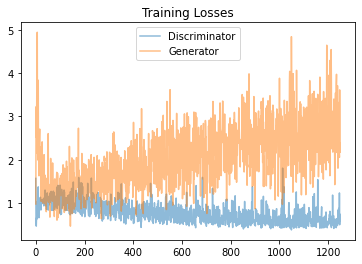

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

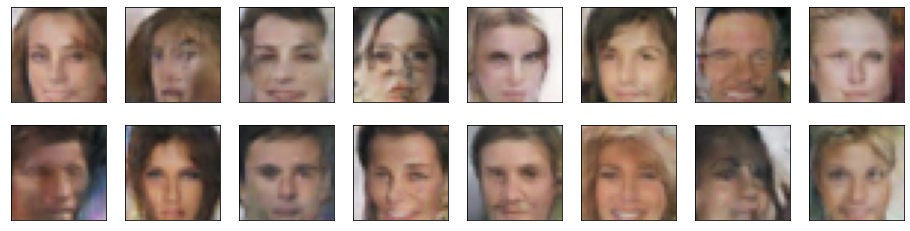

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

* Since the data set is biased, also the result will be shifted in that direction. A larger data set would be beneficial.
* Making the model larger by adding more conv and deconv layers could enable the model to learn more features. This could hopefully remove the spots which appear in the faces incorrectly.
* Trying other optimizers or a different combination of optimizers.
* Try trainig for more epochs 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.